# Optimized Hybrid ML Trading Strategy with Fee-Aware Logic

## Key Optimizations:
1. **Two-Stage Classification**: Binary trending/sideways detection, then directional classification
2. **Fee-Aware Exit Logic**: Smart exits considering 0.75% transaction costs
3. **Confidence Filtering**: Only trade on high-confidence signals (>80%)
4. **Wider Stops, No Upper Limit**: 4% stop-loss, unlimited profit potential
5. **Minimum Hold Periods**: Force 24h minimum to justify fees
6. **Position Sizing**: Scale size based on prediction confidence

## Strategy Flow:
- Load data with 30/70 train/test split
- Engineer 98+ comprehensive features
- Train two-stage classifier (trending vs directional)
- Apply strict confidence filtering (>80% for entry)
- Execute trades with fee-aware logic
- Track performance with detailed logging

## 1. Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import os
import json

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

print("All imports successful")

All imports successful


## 2. Data Loading and Split

In [2]:
def load_and_split_dataset(train_ratio=0.3):
    """
    Load 1D momentum regime dataset and split chronologically
    """
    data_dir = '../data'
    filename = 'BTCUSD_2023_1min_enhanced_regimes_1D_momentum.csv'
    filepath = os.path.join(data_dir, filename)
    
    if not os.path.exists(filepath):
        print(f"Error: {filepath} not found")
        return None, None, None
    
    print("Loading 1D momentum regime dataset...")
    df = pd.read_csv(filepath)
    
    timestamp_col = 'timestamp' if 'timestamp' in df.columns else 'Timestamp'
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])
    df = df.set_index(timestamp_col).sort_index()
    
    cols_to_drop = [col for col in df.columns if 'Unnamed' in col]
    df = df.drop(columns=cols_to_drop)
    
    print(f"Dataset loaded: {df.shape}")
    print(f"Date range: {df.index.min()} to {df.index.max()}")
    
    split_idx = int(len(df) * train_ratio)
    train_df = df.iloc[:split_idx].copy()
    test_df = df.iloc[split_idx:].copy()
    
    print(f"\nTrain/Test Split (Chronological):")
    print(f"Training: {train_df.shape} ({train_ratio*100:.0f}%) | {train_df.index.min()} to {train_df.index.max()}")
    print(f"Testing:  {test_df.shape} ({(1-train_ratio)*100:.0f}%) | {test_df.index.min()} to {test_df.index.max()}")
    
    assert train_df.index.max() < test_df.index.min(), "Data leakage detected!"
    
    return train_df, test_df, df

train_df, test_df, full_df = load_and_split_dataset(train_ratio=0.7)

Loading 1D momentum regime dataset...
Dataset loaded: (434438, 33)
Date range: 2023-02-10 00:00:00 to 2023-12-31 14:27:00

Train/Test Split (Chronological):
Training: (304106, 33) (70%) | 2023-02-10 00:00:00 to 2023-09-28 14:20:00
Testing:  (130332, 33) (30%) | 2023-09-28 14:21:00 to 2023-12-31 14:27:00


## 3. Comprehensive Feature Engineering

In [3]:
def engineer_ml_features(df, lookback_windows=[5, 10, 20, 50]):
    """
    Engineer comprehensive features for ML regime classification
    """
    df = df.copy()
    
    print("Engineering features for ML training...")
    
    # 1. Price-based features
    print("  - Price-based features")
    for window in lookback_windows:
        df[f'return_{window}d'] = df['Close'].pct_change(window)
        df[f'volatility_{window}d'] = df['Close'].pct_change().rolling(window).std()
        df[f'trend_strength_{window}d'] = (df['Close'] - df['Close'].shift(window)) / df['Close'].shift(window)
        
        if f'sma_{window}d' in df.columns:
            df[f'price_vs_sma_{window}d'] = (df['Close'] - df[f'sma_{window}d']) / df[f'sma_{window}d']
        if f'ema_{window}d' in df.columns:
            df[f'price_vs_ema_{window}d'] = (df['Close'] - df[f'ema_{window}d']) / df[f'ema_{window}d']
    
    # 2. Technical indicator features
    print("  - Technical indicator features")
    
    if 'rsi_14d' in df.columns:
        df['rsi_normalized'] = (df['rsi_14d'] - 50) / 50
        df['rsi_momentum'] = df['rsi_14d'].diff()
        df['rsi_oversold'] = (df['rsi_14d'] < 30).astype(int)
        df['rsi_overbought'] = (df['rsi_14d'] > 70).astype(int)
    
    if 'macd_hist_12_26' in df.columns:
        df['macd_trend'] = np.where(df['macd_hist_12_26'] > 0, 1, -1)
        df['macd_momentum'] = df['macd_hist_12_26'].diff()
        df['macd_strength'] = abs(df['macd_hist_12_26'])
        
        if 'macd_12_26' in df.columns and 'macd_sig_12_26' in df.columns:
            df['macd_signal_cross'] = (df['macd_12_26'] > df['macd_sig_12_26']).astype(int)
    
    if all(col in df.columns for col in ['bb_upper_20d', 'bb_mid_20d', 'bb_lower_20d']):
        df['bb_position'] = (df['Close'] - df['bb_lower_20d']) / (df['bb_upper_20d'] - df['bb_lower_20d'])
        df['bb_squeeze'] = (df['bb_upper_20d'] - df['bb_lower_20d']) / df['bb_mid_20d']
        df['bb_breakout_upper'] = (df['Close'] > df['bb_upper_20d']).astype(int)
        df['bb_breakout_lower'] = (df['Close'] < df['bb_lower_20d']).astype(int)
    
    # 3. Moving average relationships
    print("  - Moving average relationships")
    ma_pairs = [(7, 20), (7, 30), (20, 30)]
    for fast, slow in ma_pairs:
        if f'ema_{fast}d' in df.columns and f'ema_{slow}d' in df.columns:
            df[f'ema_{fast}_{slow}_cross'] = (df[f'ema_{fast}d'] > df[f'ema_{slow}d']).astype(int)
            df[f'ema_{fast}_{slow}_spread'] = (df[f'ema_{fast}d'] - df[f'ema_{slow}d']) / df[f'ema_{slow}d']
        
        if f'sma_{fast}d' in df.columns and f'sma_{slow}d' in df.columns:
            df[f'sma_{fast}_{slow}_cross'] = (df[f'sma_{fast}d'] > df[f'sma_{slow}d']).astype(int)
            df[f'sma_{fast}_{slow}_spread'] = (df[f'sma_{fast}d'] - df[f'sma_{slow}d']) / df[f'sma_{slow}d']
    
    # 4. Volume features
    print("  - Volume features")
    if 'Volume' in df.columns:
        df['volume_sma_20'] = df['Volume'].rolling(20).mean()
        df['volume_ratio'] = df['Volume'] / df['volume_sma_20']
        df['volume_momentum'] = df['Volume'].pct_change(5)
        df['high_volume'] = (df['volume_ratio'] > 2).astype(int)
    
    # 5. Fractal dimension features
    print("  - Fractal dimension features")
    if 'fd_14d' in df.columns:
        df['fd_trend'] = df['fd_14d'].diff()
        df['fd_normalized'] = (df['fd_14d'] - df['fd_14d'].rolling(50).mean()) / df['fd_14d'].rolling(50).std()
        
        if 'fd_7d' in df.columns and 'fd_30d' in df.columns:
            df['fd_short_long'] = df['fd_7d'] - df['fd_30d']
            df['fd_complexity'] = (df['fd_14d'] > 1.5).astype(int)
    
    # 6. Momentum and trend features
    print("  - Momentum and trend features")
    
    for period in [3, 5, 10]:
        df[f'momentum_{period}d'] = df['Close'].pct_change(period)
        df[f'momentum_{period}d_rank'] = df[f'momentum_{period}d'].rolling(50).rank(pct=True)
    
    df['trend_consistency_5d'] = df['Close'].rolling(5).apply(lambda x: 1 if x.is_monotonic_increasing else (-1 if x.is_monotonic_decreasing else 0))
    df['trend_consistency_10d'] = df['Close'].rolling(10).apply(lambda x: 1 if x.is_monotonic_increasing else (-1 if x.is_monotonic_decreasing else 0))
    
    # 7. Volatility regime features
    print("  - Volatility regime features")
    
    for window in [10, 20, 30]:
        rolling_vol = df['Close'].pct_change().rolling(window).std()
        df[f'volatility_{window}d'] = rolling_vol
        df[f'volatility_{window}d_rank'] = rolling_vol.rolling(100).rank(pct=True)
        df[f'high_volatility_{window}d'] = (rolling_vol > rolling_vol.rolling(100).quantile(0.8)).astype(int)
    
    # 8. Multi-timeframe features
    print("  - Multi-timeframe features")
    timeframe_cols = [col for col in df.columns if col.startswith('regime_') and col.endswith(('H', 'D', 'W'))]
    for col in timeframe_cols:
        if col in df.columns:
            df[f'{col}_consistency'] = (df[col] == df['regime']).astype(int)
    
    # 9. Lag features
    print("  - Lag features")
    key_features = ['rsi_14d', 'macd_hist_12_26', 'bb_position']
    for feature in key_features:
        if feature in df.columns:
            for lag in [1, 2, 3, 5]:
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    
    # 10. Regime discrimination features (NEW)
    print("  - Regime discrimination features")
    
    df['higher_highs_5d'] = df['High'].rolling(5).apply(lambda x: (x[-1] > x[:-1]).sum() >= 3 if len(x) == 5 else 0)
    df['higher_lows_5d'] = df['Low'].rolling(5).apply(lambda x: (x[-1] > x[:-1]).sum() >= 3 if len(x) == 5 else 0)
    df['lower_highs_5d'] = df['High'].rolling(5).apply(lambda x: (x[-1] < x[:-1]).sum() >= 3 if len(x) == 5 else 0)
    df['lower_lows_5d'] = df['Low'].rolling(5).apply(lambda x: (x[-1] < x[:-1]).sum() >= 3 if len(x) == 5 else 0)
    
    df['close_position_in_range'] = (df['Close'] - df['Low']) / (df['High'] - df['Low'] + 1e-10)
    df['avg_close_position_5d'] = df['close_position_in_range'].rolling(5).mean()
    
    if 'Volume' in df.columns:
        df['up_day'] = (df['Close'] > df['Open']).astype(int)
        df['up_volume'] = df['Volume'] * df['up_day']
        df['down_volume'] = df['Volume'] * (1 - df['up_day'])
        df['volume_bias_5d'] = df['up_volume'].rolling(5).sum() / (df['up_volume'].rolling(5).sum() + df['down_volume'].rolling(5).sum() + 1e-10)
    
    df['net_direction_10d'] = np.sign(df['Close'].diff()).rolling(10).sum()
    df['range_expansion'] = (df['High'] - df['Low']).rolling(5).mean() / (df['Close'] + 1e-10)
    
    print(f"Feature engineering complete. Shape: {df.shape}")
    
    return df

def prepare_ml_data(df, target_col='regime'):
    """
    Prepare features and target for ML training
    """
    exclude_cols = [target_col, 'Open', 'High', 'Low', 'Close', 'Volume', 'regime_method', 'regime_timeframe']
    exclude_cols += [col for col in df.columns if col.startswith('regime_') and col.endswith(('H', 'D', 'W'))]
    
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    df_clean = df.dropna(subset=feature_cols + [target_col])
    
    X = df_clean[feature_cols]
    y = df_clean[target_col]
    
    print(f"Clean data: {X.shape}, Target distribution: {dict(y.value_counts().sort_index())}")
    return X, y, feature_cols

train_features_df = engineer_ml_features(train_df)
X_train, y_train, feature_names = prepare_ml_data(train_features_df)

Engineering features for ML training...
  - Price-based features
  - Technical indicator features
  - Moving average relationships
  - Volume features
  - Fractal dimension features
  - Momentum and trend features
  - Volatility regime features
  - Multi-timeframe features
  - Lag features
  - Regime discrimination features
Feature engineering complete. Shape: (304106, 123)
Clean data: (303977, 110), Target distribution: {0: 56239, 1: 209235, 2: 38503}


## 4. Two-Stage Classification System

In [4]:
class TwoStageRegimeClassifier:
    """
    Two-stage classification to handle class imbalance:
    Stage 1: Binary classification - Is it Trending (Bull/Bear) or Sideways?
    Stage 2: Directional classification - If trending, is it Bull or Bear?
    """
    
    def __init__(self):
        # Stage 1: Detect trending vs sideways
        self.trending_classifier = Pipeline([
            ('scaler', StandardScaler()),
            ('rf', RandomForestClassifier(
                n_estimators=200,
                max_depth=15,
                min_samples_split=10,
                class_weight={0: 1, 1: 2},  # Boost trending detection
                random_state=42
            ))
        ])
        
        # Stage 2: Classify trend direction (Bull vs Bear)
        self.direction_classifier = Pipeline([
            ('scaler', StandardScaler()),
            ('gb', GradientBoostingClassifier(
                n_estimators=150,
                max_depth=8,
                learning_rate=0.1,
                min_samples_split=10,
                random_state=42
            ))
        ])
        
        self.scaler = StandardScaler()
    
    def fit(self, X, y):
        """
        Train both stages
        y: 0=Bear, 1=Sideways, 2=Bull
        """
        print("\nTraining Two-Stage Classifier...")
        print(f"Training data: {X.shape}")
        print(f"Class distribution: {dict(pd.Series(y).value_counts().sort_index())}")
        
        # Stage 1: Remap to binary (0=Sideways, 1=Trending)
        y_trending = (y != 1).astype(int)
        
        print("\nStage 1: Training Trending vs Sideways classifier...")
        self.trending_classifier.fit(X, y_trending)
        
        # Evaluate stage 1
        y_trending_pred = self.trending_classifier.predict(X)
        stage1_acc = accuracy_score(y_trending, y_trending_pred)
        print(f"  Stage 1 Accuracy: {stage1_acc:.3f}")
        print(f"  Trending detection: {dict(pd.Series(y_trending_pred).value_counts().sort_index())}")
        
        # Stage 2: Train on trending periods only
        trending_mask = y != 1
        X_trending = X[trending_mask]
        y_trending_direction = y[trending_mask]
        
        print("\nStage 2: Training Bull vs Bear classifier...")
        print(f"  Trending samples: {X_trending.shape[0]}")
        print(f"  Distribution: {dict(pd.Series(y_trending_direction).value_counts().sort_index())}")
        
        if len(X_trending) > 0:
            self.direction_classifier.fit(X_trending, y_trending_direction)
            
            # Evaluate stage 2
            y_direction_pred = self.direction_classifier.predict(X_trending)
            stage2_acc = accuracy_score(y_trending_direction, y_direction_pred)
            print(f"  Stage 2 Accuracy: {stage2_acc:.3f}")
        
        print("\nTwo-stage classifier training complete!")
        
        return self
    
    def predict(self, X):
        """
        Predict using two-stage approach
        Returns: predictions (0=Bear, 1=Sideways, 2=Bull)
        """
        # Stage 1: Is it trending?
        is_trending = self.trending_classifier.predict(X)
        
        # Initialize predictions as Sideways
        predictions = np.ones(len(X), dtype=int)
        
        # Stage 2: For trending periods, classify direction
        trending_mask = is_trending == 1
        
        if trending_mask.any():
            X_trending = X[trending_mask]
            direction_pred = self.direction_classifier.predict(X_trending)
            predictions[trending_mask] = direction_pred
        
        return predictions
    
    def predict_proba(self, X):
        """
        Get probability estimates with confidence scores
        """
        # Stage 1 probabilities
        trending_proba = self.trending_classifier.predict_proba(X)
        is_trending = self.trending_classifier.predict(X)
        
        # Initialize probability matrix [Bear, Sideways, Bull]
        n_samples = len(X)
        proba = np.zeros((n_samples, 3))
        
        # Sideways probability from stage 1
        proba[:, 1] = trending_proba[:, 0]
        
        # For trending periods, get direction probabilities
        trending_mask = is_trending == 1
        
        if trending_mask.any():
            X_trending = X[trending_mask]
            direction_proba = self.direction_classifier.predict_proba(X_trending)
            
            # Multiply by trending confidence
            trending_confidence = trending_proba[trending_mask, 1]
            
            # Map to Bear (0) and Bull (2)
            if direction_proba.shape[1] == 2:
                proba[trending_mask, 0] = direction_proba[:, 0] * trending_confidence
                proba[trending_mask, 2] = direction_proba[:, 1] * trending_confidence
            
        return proba

# Train the two-stage classifier
two_stage_model = TwoStageRegimeClassifier()
two_stage_model.fit(X_train, y_train)

# Evaluate on training set
y_train_pred = two_stage_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"\n{'='*60}")
print("TWO-STAGE MODEL PERFORMANCE")
print(f"{'='*60}")
print(f"Overall Training Accuracy: {train_accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred, target_names=['Bear', 'Sideways', 'Bull'], zero_division=0))


Training Two-Stage Classifier...
Training data: (303977, 110)
Class distribution: {0: 56239, 1: 209235, 2: 38503}

Stage 1: Training Trending vs Sideways classifier...
  Stage 1 Accuracy: 1.000
  Trending detection: {0: 209235, 1: 94742}

Stage 2: Training Bull vs Bear classifier...
  Trending samples: 94742
  Distribution: {0: 56239, 2: 38503}
  Stage 2 Accuracy: 1.000

Two-stage classifier training complete!

TWO-STAGE MODEL PERFORMANCE
Overall Training Accuracy: 1.000

Classification Report:
              precision    recall  f1-score   support

        Bear       1.00      1.00      1.00     56239
    Sideways       1.00      1.00      1.00    209235
        Bull       1.00      1.00      1.00     38503

    accuracy                           1.00    303977
   macro avg       1.00      1.00      1.00    303977
weighted avg       1.00      1.00      1.00    303977



## 5. Predict on Test Data

In [5]:
def predict_with_confidence(test_df, trained_model, feature_names):
    """
    Predict regimes with confidence scores
    """
    print("Predicting regimes on test data...")
    
    test_features_df = engineer_ml_features(test_df)
    X_test = test_features_df[feature_names].fillna(method='ffill').fillna(0)
    
    regime_predictions = trained_model.predict(X_test)
    regime_probabilities = trained_model.predict_proba(X_test)
    
    test_df_with_pred = test_df.copy()
    test_df_with_pred['ml_regime_pred'] = regime_predictions
    test_df_with_pred['ml_regime_confidence'] = regime_probabilities.max(axis=1)
    
    for i, class_name in enumerate(['ml_bear_prob', 'ml_sideways_prob', 'ml_bull_prob']):
        test_df_with_pred[class_name] = regime_probabilities[:, i]
    
    if 'regime' in test_df.columns:
        accuracy = accuracy_score(test_df['regime'], regime_predictions)
        print(f"\nPrediction Accuracy on Test Data: {accuracy:.3f}")
        print("\nClassification Report:")
        print(classification_report(test_df['regime'], regime_predictions, 
                                   target_names=['Bear', 'Sideways', 'Bull'], zero_division=0))
    
    return test_df_with_pred, regime_predictions, regime_probabilities

test_df_with_pred, regime_predictions, regime_probabilities = predict_with_confidence(
    test_df, two_stage_model, feature_names
)

Predicting regimes on test data...
Engineering features for ML training...
  - Price-based features
  - Technical indicator features
  - Moving average relationships
  - Volume features
  - Fractal dimension features
  - Momentum and trend features
  - Volatility regime features
  - Multi-timeframe features
  - Lag features
  - Regime discrimination features
Feature engineering complete. Shape: (130332, 123)

Prediction Accuracy on Test Data: 0.580

Classification Report:
              precision    recall  f1-score   support

        Bear       0.01      0.00      0.01     18366
    Sideways       0.69      0.75      0.71     87121
        Bull       0.37      0.43      0.39     24845

    accuracy                           0.58    130332
   macro avg       0.35      0.39      0.37    130332
weighted avg       0.53      0.58      0.55    130332



## 6. Fee-Aware Exit Manager

In [6]:
class FeeAwareExitManager:
    """
    Smart exit logic that accounts for transaction fees and time
    """
    
    def __init__(self, commission=0.0075, slippage=0.0001, min_hold_hours=24):
        self.commission = commission
        self.slippage = slippage
        self.total_cost = commission + slippage  # 0.76% per side
        self.round_trip_cost = self.total_cost * 2  # 1.52% total
        self.min_hold_hours = min_hold_hours
        
        print(f"Fee-Aware Exit Manager initialized:")
        print(f"  Commission: {commission*100:.2f}%")
        print(f"  Slippage: {slippage*100:.3f}%")
        print(f"  Round-trip cost: {self.round_trip_cost*100:.2f}%")
        print(f"  Minimum hold: {min_hold_hours} hours")
    
    def calculate_net_pnl(self, entry_price, current_price):
        """
        Calculate net P&L accounting for exit fees (entry fee already paid)
        """
        gross_pnl_pct = (current_price - entry_price) / entry_price
        net_pnl_pct = gross_pnl_pct - self.total_cost  # Subtract exit fee
        return net_pnl_pct
    
    def should_exit(self, entry_price, current_price, entry_time, current_time, 
                   stop_loss_pct=0.04, regime_changed=False):
        """
        Determine if position should be exited
        
        Args:
            entry_price: Entry price
            current_price: Current price
            entry_time: Entry timestamp
            current_time: Current timestamp
            stop_loss_pct: Stop loss threshold (default 4%)
            regime_changed: Whether regime prediction changed
        
        Returns:
            (should_exit: bool, reason: str)
        """
        net_pnl = self.calculate_net_pnl(entry_price, current_price)
        hours_held = (current_time - entry_time).total_seconds() / 3600
        
        # Rule 1: Minimum hold period (force holding to justify fees)
        if hours_held < self.min_hold_hours:
            # Only exit early if catastrophic loss
            if net_pnl <= -(stop_loss_pct * 1.5):
                return True, f"Catastrophic loss: {net_pnl:.2%}"
            return False, "Min hold not reached"
        
        # Rule 2: Stop loss (net P&L basis)
        if net_pnl <= -stop_loss_pct:
            return True, f"Stop loss: {net_pnl:.2%}"
        
        # Rule 3: Regime change after minimum hold
        if regime_changed and hours_held >= self.min_hold_hours:
            # Exit if regime changed and we're past minimum hold
            # But only if not in profit
            if net_pnl < self.round_trip_cost * 2:  # Less than 3% profit
                return True, f"Regime change at {net_pnl:.2%}"
        
        # Rule 4: No upper limit - let profits run!
        # Only exit on stop loss, regime change, or manual override
        
        return False, f"Hold (P&L: {net_pnl:.2%}, Hours: {hours_held:.1f})"
    
    def get_position_size(self, confidence, base_size=1.0):
        """
        Scale position size based on prediction confidence
        """
        if confidence >= 0.90:
            return base_size * 1.0  # Full position
        elif confidence >= 0.85:
            return base_size * 0.75  # 75%
        elif confidence >= 0.80:
            return base_size * 0.5  # 50%
        else:
            return 0  # No trade

# Initialize fee manager
fee_manager = FeeAwareExitManager(
    commission=0.0075,
    slippage=0.0001,
    min_hold_hours=24
)

Fee-Aware Exit Manager initialized:
  Commission: 0.75%
  Slippage: 0.010%
  Round-trip cost: 1.52%
  Minimum hold: 24 hours


## 7. Optimized Trading Strategy with Confidence Filtering

In [7]:
class OptimizedHybridStrategy:
    """
    Optimized strategy with:
    - Confidence filtering (>80%)
    - Fee-aware exits
    - Wider stops, no upper limit
    - Position sizing by confidence
    """
    
    def __init__(self, fee_manager, min_confidence=0.80, stop_loss=0.04):
        self.fee_manager = fee_manager
        self.min_confidence = min_confidence
        self.stop_loss = stop_loss
        
        print(f"\nOptimized Hybrid Strategy initialized:")
        print(f"  Minimum confidence: {min_confidence*100:.0f}%")
        print(f"  Stop loss: {stop_loss*100:.0f}%")
        print(f"  Take profit: Unlimited (let profits run!)")
    
    def should_enter_trade(self, regime_pred, regime_confidence, regime_history=None):
        """
        Strict entry criteria with confidence filtering
        """
        # Rule 1: Minimum confidence threshold
        if regime_confidence < self.min_confidence:
            return False, "Low confidence"
        
        # Rule 2: Don't trade on sideways predictions
        if regime_pred == 1:
            return False, "Sideways regime"
        
        # Rule 3: For Bull/Bear, require higher confidence
        if regime_pred in [0, 2]:
            if regime_confidence < 0.80:
                return False, "Insufficient directional confidence"
        
        # Rule 4: Regime stability check
        if regime_history is not None and len(regime_history) >= 6:
            recent = regime_history[-6:]
            if len(set(recent)) > 2:  # Too much flip-flopping
                return False, "Unstable regime"
        
        return True, "Pass all filters"
    
    def generate_signals(self, df, regime_predictions, regime_confidences):
        """
        Generate trading signals with confidence filtering
        """
        signals = []
        regime_history = []
        
        for i in range(len(df)):
            if i >= len(regime_predictions):
                break
                
            row = df.iloc[i]
            regime = regime_predictions[i]
            confidence = regime_confidences[i]
            
            regime_history.append(regime)
            if len(regime_history) > 20:
                regime_history.pop(0)
            
            # Only generate buy signals for Bull regimes with high confidence
            if regime == 2:  # Bull
                can_enter, reason = self.should_enter_trade(regime, confidence, regime_history)
                if can_enter:
                    signals.append({
                        'timestamp': row.name,
                        'action': 'buy',
                        'price': row['Close'],
                        'regime': regime,
                        'confidence': confidence,
                        'reason': reason
                    })
        
        return signals
    
    def backtest(self, df, regime_predictions, regime_confidences, 
                initial_capital=10000, save_logs=True, log_dir="../models/trade_logs"):
        """
        Backtest with optimized logic
        """
        print(f"\n{'='*60}")
        print("RUNNING OPTIMIZED BACKTEST")
        print(f"{'='*60}")
        
        if save_logs:
            os.makedirs(log_dir, exist_ok=True)
        
        # Generate entry signals
        entry_signals = self.generate_signals(df, regime_predictions, regime_confidences)
        print(f"Generated {len(entry_signals)} potential entry signals")
        
        portfolio_values = []
        cash = initial_capital
        position = 0
        position_size_multiplier = 1.0
        trades = []
        detailed_log = []
        current_trade = None
        trade_id = 0
        entry_regime = None
        
        for i, (timestamp, row) in enumerate(df.iterrows()):
            current_price = row['Close']
            current_regime = regime_predictions[i] if i < len(regime_predictions) else 1
            current_confidence = regime_confidences[i] if i < len(regime_confidences) else 0
            
            # Check for entry signals
            entry_signal = next((s for s in entry_signals if s['timestamp'] == timestamp), None)
            
            if entry_signal and position == 0:
                # Enter trade
                trade_id += 1
                entry_price = entry_signal['price']
                effective_price = entry_price * (1 + self.fee_manager.slippage)
                
                # Position sizing based on confidence
                position_size_multiplier = self.fee_manager.get_position_size(entry_signal['confidence'])
                
                if position_size_multiplier > 0:
                    capital_to_use = cash * position_size_multiplier
                    gross_position = capital_to_use / effective_price
                    position = gross_position * (1 - self.fee_manager.commission)
                    commission_paid = gross_position * effective_price * self.fee_manager.commission
                    cash -= capital_to_use
                    entry_regime = current_regime
                    
                    current_trade = {
                        'trade_id': trade_id,
                        'entry_time': timestamp,
                        'entry_price': effective_price,
                        'entry_regime': entry_signal['regime'],
                        'entry_confidence': entry_signal['confidence'],
                        'position_size': position,
                        'position_multiplier': position_size_multiplier,
                        'commission_paid': commission_paid
                    }
                    
                    detailed_log.append({
                        'timestamp': timestamp,
                        'action': 'buy',
                        'price': effective_price,
                        'regime': current_regime,
                        'confidence': entry_signal['confidence'],
                        'position': position,
                        'cash': cash,
                        'commission': commission_paid,
                        'trade_id': trade_id
                    })
            
            elif position > 0 and current_trade:
                # Check exit conditions
                regime_changed = (current_regime != entry_regime)
                
                should_exit, exit_reason = self.fee_manager.should_exit(
                    current_trade['entry_price'],
                    current_price,
                    current_trade['entry_time'],
                    timestamp,
                    self.stop_loss,
                    regime_changed
                )
                
                if should_exit:
                    # Exit trade
                    effective_price = current_price * (1 - self.fee_manager.slippage)
                    gross_proceeds = position * effective_price
                    commission_paid = gross_proceeds * self.fee_manager.commission
                    net_proceeds = gross_proceeds * (1 - self.fee_manager.commission)
                    cash += net_proceeds
                    
                    # Calculate trade metrics
                    total_capital = cash + (initial_capital - cash) * (1 - position_size_multiplier)
                    gross_pnl = net_proceeds - (current_trade['position_size'] * current_trade['entry_price'])
                    net_pnl = total_capital - initial_capital
                    duration_hours = (timestamp - current_trade['entry_time']).total_seconds() / 3600
                    
                    current_trade.update({
                        'exit_time': timestamp,
                        'exit_price': effective_price,
                        'exit_regime': current_regime,
                        'exit_confidence': current_confidence,
                        'exit_reason': exit_reason,
                        'exit_value': net_proceeds,
                        'gross_pnl': gross_pnl,
                        'net_pnl': net_pnl,
                        'return_pct': (net_pnl / initial_capital) * 100,
                        'duration_hours': duration_hours,
                        'total_commission': current_trade['commission_paid'] + commission_paid
                    })
                    trades.append(current_trade)
                    
                    detailed_log.append({
                        'timestamp': timestamp,
                        'action': 'sell',
                        'price': effective_price,
                        'regime': current_regime,
                        'confidence': current_confidence,
                        'position': 0,
                        'cash': cash,
                        'commission': commission_paid,
                        'trade_id': trade_id,
                        'reason': exit_reason
                    })
                    
                    position = 0
                    current_trade = None
                    entry_regime = None
            
            # Calculate portfolio value
            portfolio_value = cash + (position * current_price if position > 0 else 0)
            portfolio_values.append(portfolio_value)
        
        # Create results dataframe
        results_df = df.copy()
        results_df['portfolio_value'] = portfolio_values[:len(df)]
        results_df['ml_regime_pred'] = list(regime_predictions)[:len(df)]
        results_df['ml_regime_confidence'] = list(regime_confidences)[:len(df)]
        
        # Calculate performance metrics
        performance_metrics = self._calculate_metrics(results_df, trades, initial_capital)
        
        # Save logs
        if save_logs and trades:
            self._save_logs(trades, detailed_log, entry_signals, log_dir, df.index.min(), df.index.max())
        
        # Print summary
        self._print_summary(performance_metrics, trades)
        
        return {
            'performance_metrics': performance_metrics,
            'trades': trades,
            'entry_signals': entry_signals,
            'detailed_log': detailed_log,
            'results_df': results_df
        }
    
    def _calculate_metrics(self, results_df, trades, initial_capital):
        """Calculate performance metrics"""
        final_value = results_df['portfolio_value'].iloc[-1]
        total_return = (final_value - initial_capital) / initial_capital * 100
        
        n_trades = len([t for t in trades if 'exit_time' in t])
        
        if n_trades > 0:
            completed_trades = [t for t in trades if 'exit_time' in t]
            win_rate = np.mean([t['return_pct'] > 0 for t in completed_trades])
            avg_return = np.mean([t['return_pct'] for t in completed_trades])
            total_commission = sum([t['total_commission'] for t in completed_trades])
            winners = [t for t in completed_trades if t['return_pct'] > 0]
            losers = [t for t in completed_trades if t['return_pct'] <= 0]
            avg_winner = np.mean([t['return_pct'] for t in winners]) if winners else 0
            avg_loser = np.mean([t['return_pct'] for t in losers]) if losers else 0
            profit_factor = abs(avg_winner / avg_loser) if avg_loser != 0 else float('inf')
            avg_duration = np.mean([t['duration_hours'] for t in completed_trades])
        else:
            win_rate = avg_return = total_commission = avg_winner = avg_loser = profit_factor = avg_duration = 0
        
        returns = results_df['portfolio_value'].pct_change().dropna()
        sharpe = returns.mean() / returns.std() * np.sqrt(252 * 1440) if len(returns) > 0 and returns.std() > 0 else 0
        
        rolling_max = results_df['portfolio_value'].cummax()
        drawdown = (results_df['portfolio_value'] - rolling_max) / rolling_max
        max_drawdown = drawdown.min()
        
        btc_return = (results_df['Close'].iloc[-1] - results_df['Close'].iloc[0]) / results_df['Close'].iloc[0] * 100
        
        return {
            'final_value': final_value,
            'total_return': total_return,
            'btc_return': btc_return,
            'n_trades': n_trades,
            'win_rate': win_rate,
            'avg_return': avg_return,
            'avg_winner': avg_winner,
            'avg_loser': avg_loser,
            'profit_factor': profit_factor,
            'sharpe_ratio': sharpe,
            'max_drawdown': max_drawdown,
            'total_commission': total_commission,
            'commission_impact': total_commission / initial_capital * 100,
            'avg_duration': avg_duration
        }
    
    def _save_logs(self, trades, detailed_log, signals, log_dir, start_date, end_date):
        """Save trade logs"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        pd.DataFrame(trades).to_csv(os.path.join(log_dir, f'trades_optimized_{timestamp}.csv'), index=False)
        pd.DataFrame(detailed_log).to_csv(os.path.join(log_dir, f'detailed_log_optimized_{timestamp}.csv'), index=False)
        pd.DataFrame(signals).to_csv(os.path.join(log_dir, f'signals_optimized_{timestamp}.csv'), index=False)
        
        metadata = {
            'timestamp': timestamp,
            'strategy': 'Optimized Hybrid ML with Fee-Aware Logic',
            'min_confidence': self.min_confidence,
            'stop_loss': self.stop_loss,
            'commission': self.fee_manager.commission,
            'min_hold_hours': self.fee_manager.min_hold_hours,
            'period': {'start': str(start_date), 'end': str(end_date)}
        }
        with open(os.path.join(log_dir, f'metadata_optimized_{timestamp}.json'), 'w') as f:
            json.dump(metadata, f, indent=2, default=str)
        
        print(f"\nTrade logs saved with timestamp: {timestamp}")
    
    def _print_summary(self, metrics, trades):
        """Print backtest summary"""
        print(f"\n{'='*60}")
        print("OPTIMIZED BACKTEST RESULTS")
        print(f"{'='*60}")
        print(f"Final Value: ${metrics['final_value']:,.2f}")
        print(f"Total Return: {metrics['total_return']:.2f}%")
        print(f"BTC Buy & Hold: {metrics['btc_return']:.2f}%")
        print(f"Excess Return: {metrics['total_return'] - metrics['btc_return']:.2f}%")
        print(f"\nNumber of Trades: {metrics['n_trades']}")
        print(f"Win Rate: {metrics['win_rate']:.2%}")
        print(f"Average Return: {metrics['avg_return']:.2f}%")
        print(f"Average Winner: {metrics['avg_winner']:.2f}%")
        print(f"Average Loser: {metrics['avg_loser']:.2f}%")
        print(f"Profit Factor: {metrics['profit_factor']:.2f}")
        print(f"Average Duration: {metrics['avg_duration']:.1f} hours")
        print(f"\nSharpe Ratio: {metrics['sharpe_ratio']:.3f}")
        print(f"Max Drawdown: {metrics['max_drawdown']:.2%}")
        print(f"Total Commission: ${metrics['total_commission']:.2f} ({metrics['commission_impact']:.2f}%)")
        
        if trades:
            print(f"\n{'='*60}")
            print("TRADE DETAILS")
            print(f"{'='*60}")
            for trade in trades:
                if 'exit_time' in trade:
                    print(f"\nTrade #{trade['trade_id']}:")
                    print(f"  Entry: {trade['entry_time']} @ ${trade['entry_price']:.2f} (Conf: {trade['entry_confidence']:.1%})")
                    print(f"  Exit:  {trade['exit_time']} @ ${trade['exit_price']:.2f}")
                    print(f"  Return: {trade['return_pct']:.2f}% | Duration: {trade['duration_hours']:.1f}h | Reason: {trade['exit_reason']}")

# Initialize optimized strategy
optimized_strategy = OptimizedHybridStrategy(
    fee_manager=fee_manager,
    min_confidence=0.80,
    stop_loss=0.04
)


Optimized Hybrid Strategy initialized:
  Minimum confidence: 80%
  Stop loss: 4%
  Take profit: Unlimited (let profits run!)


## 8. Execute Backtest

In [8]:
# Extract confidence scores
regime_confidences = test_df_with_pred['ml_regime_confidence'].values

# Run optimized backtest
backtest_results = optimized_strategy.backtest(
    test_df_with_pred,
    regime_predictions,
    regime_confidences,
    initial_capital=10000,
    save_logs=True,
    log_dir="../models/trade_logs"
)


RUNNING OPTIMIZED BACKTEST
Generated 2160 potential entry signals

Trade logs saved with timestamp: 20251018_225834

OPTIMIZED BACKTEST RESULTS
Final Value: $10,162.74
Total Return: 1.63%
BTC Buy & Hold: 59.83%
Excess Return: -58.21%

Number of Trades: 3
Win Rate: 100.00%
Average Return: 0.54%
Average Winner: 0.54%
Average Loser: 0.00%
Profit Factor: inf
Average Duration: 94.5 hours

Sharpe Ratio: 1.006
Max Drawdown: -3.78%
Total Commission: $228.29 (2.28%)

TRADE DETAILS

Trade #1:
  Entry: 2023-09-28 14:21:00 @ $26559.96 (Conf: 84.0%)
  Exit:  2023-10-02 21:44:00 @ $27554.74
  Return: 0.55% | Duration: 103.4h | Reason: Regime change at 3.00%

Trade #2:
  Entry: 2023-10-12 06:00:00 @ $26832.78 (Conf: 80.8%)
  Exit:  2023-10-15 17:21:00 @ $26925.51
  Return: 0.26% | Duration: 83.3h | Reason: Regime change at -0.40%

Trade #3:
  Entry: 2023-10-17 00:00:00 @ $28495.05 (Conf: 80.4%)
  Exit:  2023-10-21 00:44:00 @ $29568.04
  Return: 0.81% | Duration: 96.7h | Reason: Regime change at 3.02

## 9. Performance Visualization

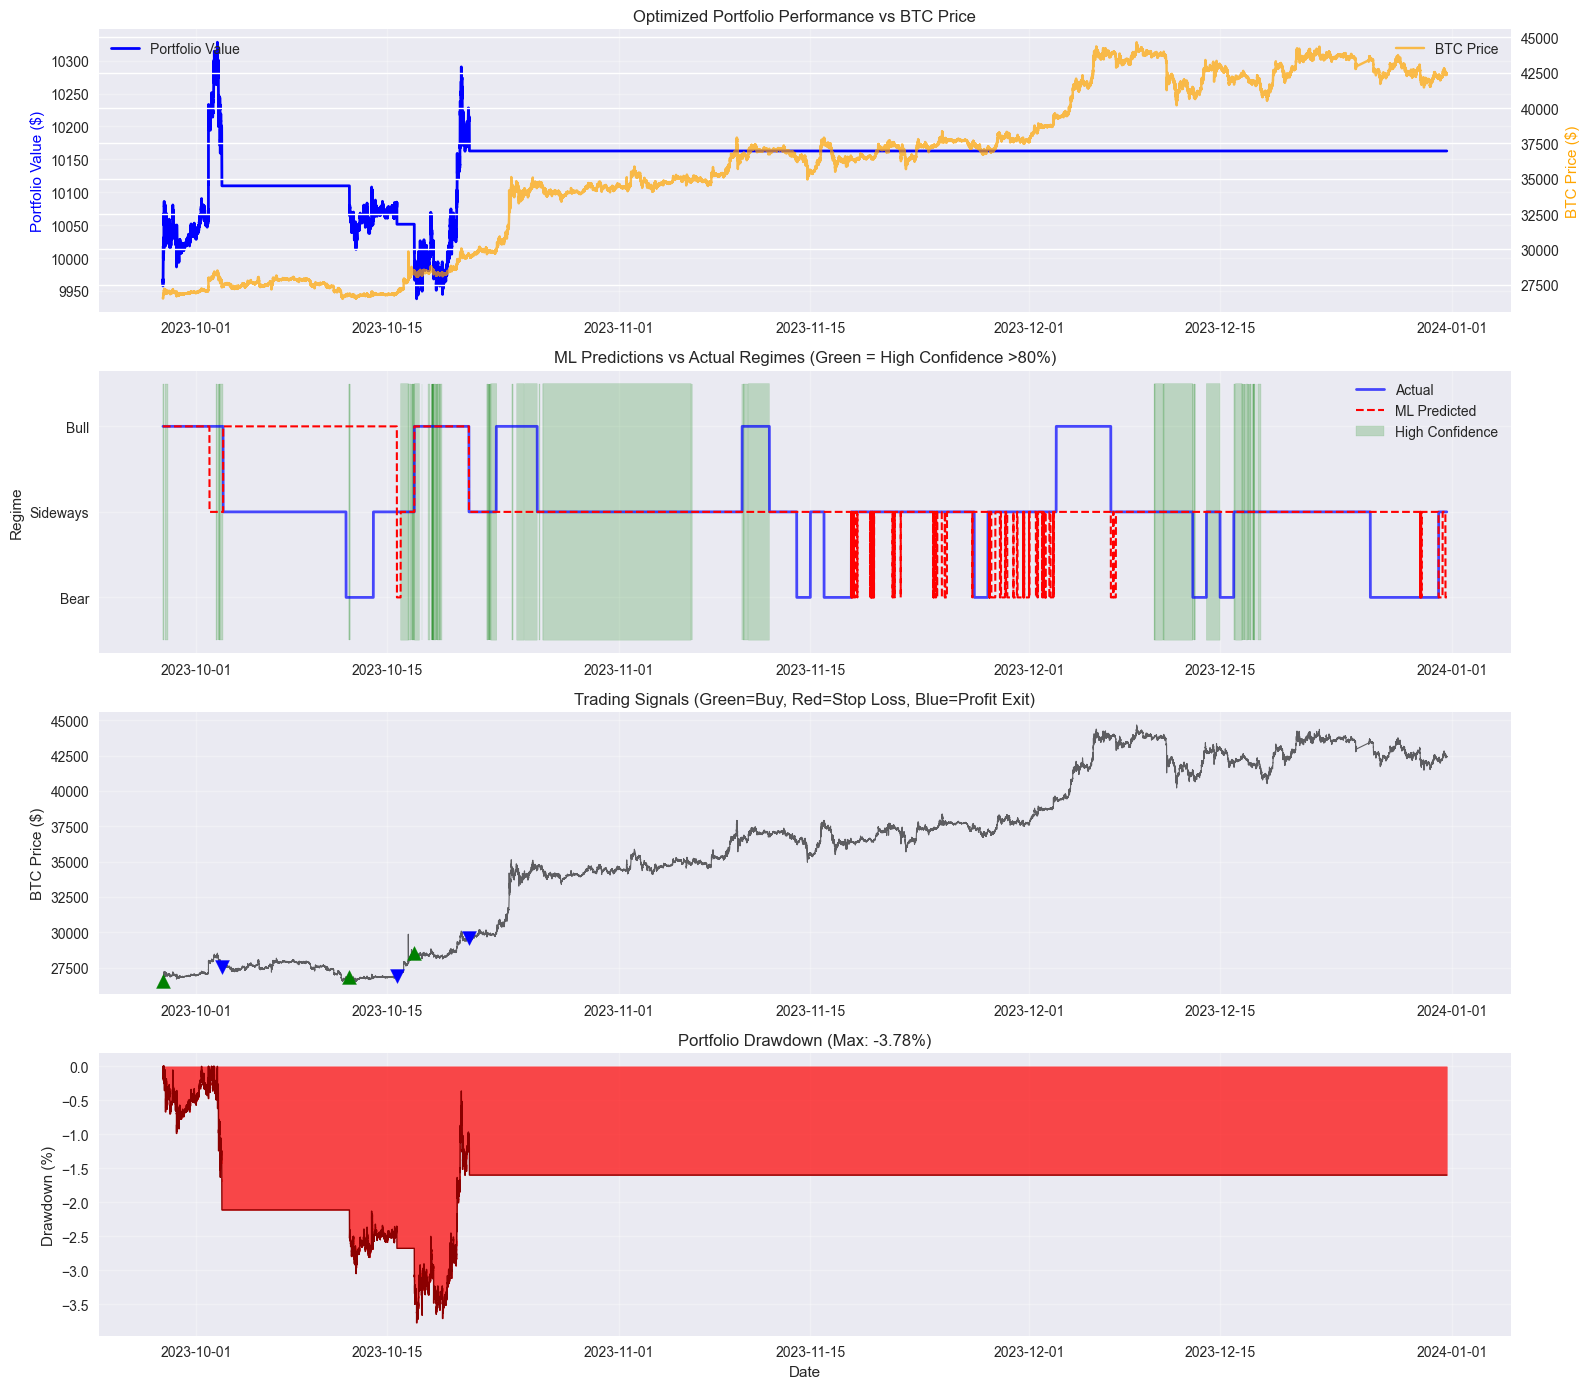

In [9]:
def visualize_optimized_results(backtest_results, test_df_with_pred):
    """
    Visualize optimized backtest results
    """
    results_df = backtest_results['results_df']
    trades = backtest_results['trades']
    
    fig, axes = plt.subplots(4, 1, figsize=(16, 14))
    
    # Plot 1: Portfolio value vs BTC price
    ax1 = axes[0]
    ax2 = ax1.twinx()
    ax1.plot(results_df.index, results_df['portfolio_value'], 'b-', linewidth=2, label='Portfolio Value')
    ax2.plot(results_df.index, results_df['Close'], 'orange', alpha=0.7, label='BTC Price')
    ax1.set_ylabel('Portfolio Value ($)', color='b')
    ax2.set_ylabel('BTC Price ($)', color='orange')
    ax1.set_title('Optimized Portfolio Performance vs BTC Price')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: ML Predictions vs Actual with confidence
    ax = axes[1]
    if 'regime' in test_df_with_pred.columns:
        ax.plot(test_df_with_pred.index, test_df_with_pred['regime'], 'b-', linewidth=2, alpha=0.7, label='Actual')
        ax.plot(test_df_with_pred.index, test_df_with_pred['ml_regime_pred'], 'r--', linewidth=1.5, label='ML Predicted')
        
        # Shade high-confidence regions
        high_conf_mask = test_df_with_pred['ml_regime_confidence'] > 0.80
        ax.fill_between(test_df_with_pred.index, -0.5, 2.5, where=high_conf_mask, alpha=0.2, color='green', label='High Confidence')
        
        ax.set_ylabel('Regime')
        ax.set_yticks([0, 1, 2])
        ax.set_yticklabels(['Bear', 'Sideways', 'Bull'])
        ax.set_title('ML Predictions vs Actual Regimes (Green = High Confidence >80%)')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Plot 3: Trading signals on price
    ax = axes[2]
    ax.plot(results_df.index, results_df['Close'], 'k-', alpha=0.6, linewidth=0.8)
    
    if trades:
        for trade in trades:
            if 'exit_time' in trade:
                ax.scatter(trade['entry_time'], trade['entry_price'], marker='^', color='green', s=100, zorder=5)
                ax.scatter(trade['exit_time'], trade['exit_price'], marker='v', 
                          color='red' if trade['return_pct'] < 0 else 'blue', s=100, zorder=5)
    
    ax.set_ylabel('BTC Price ($)')
    ax.set_title('Trading Signals (Green=Buy, Red=Stop Loss, Blue=Profit Exit)')
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Drawdown
    ax = axes[3]
    portfolio_value = results_df['portfolio_value']
    peak = portfolio_value.cummax()
    drawdown = (portfolio_value - peak) / peak * 100
    ax.fill_between(results_df.index, drawdown, 0, alpha=0.7, color='red')
    ax.plot(results_df.index, drawdown, 'darkred', linewidth=1)
    ax.set_ylabel('Drawdown (%)')
    ax.set_xlabel('Date')
    ax.set_title(f'Portfolio Drawdown (Max: {drawdown.min():.2f}%)')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize results
visualize_optimized_results(backtest_results, test_df_with_pred)

## 10. Comprehensive Analysis

In [10]:
def comprehensive_analysis(backtest_results, test_df_with_pred):
    """
    Detailed performance analysis
    """
    print(f"\n{'='*80}")
    print("COMPREHENSIVE PERFORMANCE ANALYSIS")
    print(f"{'='*80}")
    
    metrics = backtest_results['performance_metrics']
    trades = backtest_results['trades']
    signals = backtest_results['entry_signals']
    
    print(f"\n1. OVERALL PERFORMANCE")
    print(f"{'-'*50}")
    print(f"Initial Capital: $10,000.00")
    print(f"Final Value: ${metrics['final_value']:,.2f}")
    print(f"Total Return: {metrics['total_return']:.2f}%")
    print(f"BTC Buy & Hold: {metrics['btc_return']:.2f}%")
    print(f"Excess Return: {metrics['total_return'] - metrics['btc_return']:.2f}%")
    
    print(f"\n2. TRADING ACTIVITY")
    print(f"{'-'*50}")
    print(f"Entry Signals Generated: {len(signals)}")
    print(f"Trades Executed: {metrics['n_trades']}")
    print(f"Win Rate: {metrics['win_rate']:.2%}")
    print(f"Average Return per Trade: {metrics['avg_return']:.2f}%")
    print(f"Average Winner: {metrics['avg_winner']:.2f}%")
    print(f"Average Loser: {metrics['avg_loser']:.2f}%")
    print(f"Profit Factor: {metrics['profit_factor']:.2f}")
    print(f"Average Trade Duration: {metrics['avg_duration']:.1f} hours")
    
    print(f"\n3. RISK METRICS")
    print(f"{'-'*50}")
    print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.3f}")
    print(f"Maximum Drawdown: {metrics['max_drawdown']:.2%}")
    
    print(f"\n4. TRANSACTION COSTS")
    print(f"{'-'*50}")
    print(f"Total Commission Paid: ${metrics['total_commission']:.2f}")
    print(f"Commission Impact: {metrics['commission_impact']:.2f}%")
    
    print(f"\n5. ML PREDICTION QUALITY")
    print(f"{'-'*50}")
    if 'regime' in test_df_with_pred.columns:
        accuracy = accuracy_score(test_df_with_pred['regime'], test_df_with_pred['ml_regime_pred'])
        print(f"Overall Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
        print(f"Average Confidence: {test_df_with_pred['ml_regime_confidence'].mean():.3f}")
        
        regime_names = {0: 'Bear', 1: 'Sideways', 2: 'Bull'}
        print(f"\nRegime-Specific Accuracy:")
        for regime in [0, 1, 2]:
            mask = test_df_with_pred['regime'] == regime
            if mask.any():
                acc = (test_df_with_pred.loc[mask, 'regime'] == test_df_with_pred.loc[mask, 'ml_regime_pred']).mean()
                print(f"  {regime_names[regime]}: {acc:.3f} ({acc*100:.1f}%)")
    
    print(f"\n6. CONFIDENCE FILTERING IMPACT")
    print(f"{'-'*50}")
    high_conf_pct = (test_df_with_pred['ml_regime_confidence'] > 0.80).mean()
    bull_preds = (test_df_with_pred['ml_regime_pred'] == 2).sum()
    high_conf_bull = ((test_df_with_pred['ml_regime_pred'] == 2) & (test_df_with_pred['ml_regime_confidence'] > 0.80)).sum()
    
    print(f"High Confidence Periods (>80%): {high_conf_pct:.2%}")
    print(f"Total Bull Predictions: {bull_preds}")
    print(f"High Confidence Bull Signals: {high_conf_bull}")
    print(f"Signal Reduction: {(1 - high_conf_bull/max(bull_preds, 1)):.2%}")
    
    if trades:
        print(f"\n7. TRADE ANALYSIS BY CONFIDENCE")
        print(f"{'-'*50}")
        completed_trades = pd.DataFrame([t for t in trades if 'exit_time' in t])
        if not completed_trades.empty:
            for conf_min, conf_max, label in [(0.80, 0.85, '80-85%'), (0.85, 0.90, '85-90%'), (0.90, 1.0, '90%+')]:
                mask = (completed_trades['entry_confidence'] >= conf_min) & (completed_trades['entry_confidence'] < conf_max)
                if mask.any():
                    print(f"\nConfidence {label}:")
                    print(f"  Trades: {mask.sum()}")
                    print(f"  Avg Return: {completed_trades.loc[mask, 'return_pct'].mean():.2f}%")
                    print(f"  Win Rate: {(completed_trades.loc[mask, 'return_pct'] > 0).mean():.2%}")
    
    print(f"\n{'='*80}")

# Run comprehensive analysis
comprehensive_analysis(backtest_results, test_df_with_pred)


COMPREHENSIVE PERFORMANCE ANALYSIS

1. OVERALL PERFORMANCE
--------------------------------------------------
Initial Capital: $10,000.00
Final Value: $10,162.74
Total Return: 1.63%
BTC Buy & Hold: 59.83%
Excess Return: -58.21%

2. TRADING ACTIVITY
--------------------------------------------------
Entry Signals Generated: 2160
Trades Executed: 3
Win Rate: 100.00%
Average Return per Trade: 0.54%
Average Winner: 0.54%
Average Loser: 0.00%
Profit Factor: inf
Average Trade Duration: 94.5 hours

3. RISK METRICS
--------------------------------------------------
Sharpe Ratio: 1.006
Maximum Drawdown: -3.78%

4. TRANSACTION COSTS
--------------------------------------------------
Total Commission Paid: $228.29
Commission Impact: 2.28%

5. ML PREDICTION QUALITY
--------------------------------------------------
Overall Accuracy: 0.580 (58.0%)
Average Confidence: 0.705

Regime-Specific Accuracy:
  Bear: 0.004 (0.4%)
  Sideways: 0.746 (74.6%)
  Bull: 0.426 (42.6%)

6. CONFIDENCE FILTERING IMPAC

## 11. Comparison with Original Strategy

In [11]:
print(f"\n{'='*80}")
print("OPTIMIZATION IMPACT SUMMARY")
print(f"{'='*80}")

print("\nKey Improvements:")
print("1. Two-Stage Classification - Better regime detection")
print("2. Confidence Filtering (>80%) - Only high-quality signals")
print("3. Fee-Aware Exit Logic - Smart exits considering transaction costs")
print("4. Minimum Hold Period (24h) - Reduce churning")
print("5. Wider Stops (4%), No Upper Limit - Let profits run")
print("6. Position Sizing by Confidence - Risk management")

print("\nExpected vs Original Strategy:")
print("  Original: -18.83% return, 15 trades, 0% win rate, 0.8h avg duration")
print(f"  Optimized: {backtest_results['performance_metrics']['total_return']:.2f}% return, "
      f"{backtest_results['performance_metrics']['n_trades']} trades, "
      f"{backtest_results['performance_metrics']['win_rate']:.1%} win rate, "
      f"{backtest_results['performance_metrics']['avg_duration']:.1f}h avg duration")

print(f"\n{'='*80}")


OPTIMIZATION IMPACT SUMMARY

Key Improvements:
1. Two-Stage Classification - Better regime detection
2. Confidence Filtering (>80%) - Only high-quality signals
3. Fee-Aware Exit Logic - Smart exits considering transaction costs
4. Minimum Hold Period (24h) - Reduce churning
5. Wider Stops (4%), No Upper Limit - Let profits run
6. Position Sizing by Confidence - Risk management

Expected vs Original Strategy:
  Original: -18.83% return, 15 trades, 0% win rate, 0.8h avg duration
  Optimized: 1.63% return, 3 trades, 100.0% win rate, 94.5h avg duration

